# DSCI 100 - Course Project Report 

Title: Predicting Credit Card Default

Group 10: Berkay Talha Acar, Stephen Pon

# Introduction 

The dataset we will use for our analysis is called “default of credit card clients”. It is credit card data collected in Taiwan by Chung Hua University. A credit card default is when a client fails to repay their credit card debt consisting of principal, interest, or both. A default can occur when a borrower misses, avoids, stops, or fails to make timely payments. Risks associated with default are often calculated in advance by credit card issuers who set a limit on the clients’ debt. 

In this project, we will build a K-nearest neighbors classification model that can predict whether a subset of clients with a university education will default based on various credit risk metrics.

# Methods and Results 

After the appropriate libraries are downloaded, the dataset can be read from the web into R as follows:

In [33]:
library(tidyverse)
library(readxl)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)
#library(GGally)
library(ISLR)
library(gridExtra)

In [2]:
set.seed(19) # set the seed for reproducibility
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
download.file(url, "credit_default.xls")
cd <- read_excel("credit_default.xls", skip = 1)
head(cd)
dim(cd)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


[1] 30000    25

We see that our dataset is 30,000 by 25, and to clean our dataset, we will first remove the spaces from column names and filter for people with university degree.

In [3]:
colnames(cd) <- make.names(colnames(cd)) # remove the spaces from column names 
cd_university <- cd %>%
                filter(EDUCATION == 2) # university education
head(cd_university)
dim(cd_university) # let's see the dimensions after filtered for cd_university, which is 14030x25

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
8,100000,2,2,2,23,0,-1,-1,0,⋯,221,-159,567,380,601,0,581,1687,1542,0


[1] 14030    25

Next, we randomly sample 10,000 rows from our dataset to avoid spending a lot of time training our model, or crashing the server with too many observations, and to eliminate bias that might exist in our initial dataset. We also think that it is valuable to have enough data in training, so that our model can learn and generalize from examples.

In [4]:
#sample 10,000 random rows since load times get very long with too much data
cd_sample <- sample_n(cd_university, 10000) %>% # sample 10,000 rows
        rename(default_nm = default.payment.next.month, # rename the classification variable 
                limit = LIMIT_BAL) %>%
        mutate(default_nm = as_factor(default_nm), # factor our classsification variable 
              bill_avg = ((BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6)/6), # average of bills
              pay_avg = ((PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6)/6)) # average of payments
head(cd_sample)
tail(cd_sample)
dim(cd_sample) # our initial data frame with 10,000 rows and  27 columns

ID,limit,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_nm,bill_avg,pay_avg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
16487,120000,2,2,1,54,0,0,0,0,⋯,80597,3072,3074,2887,2774,2871,3000,0,84163.33,2946.333
20984,20000,1,2,2,34,2,2,2,0,⋯,19232,3500,0,1500,805,7000,542,1,19474.17,2224.500
9773,120000,1,2,2,39,1,-1,2,2,⋯,0,1170,0,0,0,0,0,0,260.00,195.000
16232,480000,2,2,2,34,0,0,0,0,⋯,209218,18231,20010,13013,11209,9010,162510,1,385100.67,38997.167
6078,100000,2,2,2,26,0,0,0,-1,⋯,11329,1227,1150,1600,8000,5000,0,0,12117.33,2829.500
10469,240000,2,2,2,28,0,0,0,0,⋯,83742,6000,5000,4000,4000,4000,3000,0,112239.00,4333.333


ID,limit,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_nm,bill_avg,pay_avg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
10584,50000,1,2,2,38,1,2,0,0,⋯,31036,0,5000,10000,5000,2500,0,0,34946.667,3750.0000
26164,200000,2,2,1,27,0,0,0,0,⋯,172430,7200,5888,5990,6031,6415,6301,0,164378.167,6304.1667
23295,30000,2,2,2,31,0,0,0,-2,⋯,0,5000,0,0,0,0,0,0,9621.667,833.3333
5148,50000,2,2,2,25,1,2,2,2,⋯,17316,2000,0,2000,0,2000,0,1,15474.833,1000.0000
27905,230000,2,2,1,29,1,2,0,0,⋯,118933,4800,4600,4300,4700,5124,4110,0,115231.167,4605.6667
1580,120000,2,2,1,38,-1,-1,-1,-1,⋯,970,7270,820,820,2870,970,820,0,2808.333,2261.6667


[1] 10000    27

We split our data into training (75%) and testing (25%) datasets. 75% of the dataset is chosen for training, because we need much more data for training, and 25% is more than enough for testing our model. We will only use the training set for our exploratory analysis.

In [5]:
cd_split <- initial_split(cd_sample, prop=0.75, strata=default_nm)
cd_training <- training(cd_split)
cd_testing <- testing(cd_split)

Here, we create our variables of interest. `usage_cdt` and `pmt` represent, on average, the client's bills and payments as a proportion of their available credit card limit.

In [6]:
cd_training <- cd_training %>%
        mutate(payment_to_bill_ratio = pay_avg/bill_avg) %>%  # the ratio of their average payment to average bill    
        mutate(usage_cdt = bill_avg/limit) %>% # to see how much of their balance they use 
        mutate(pmt = pay_avg/limit) %>% # to see how much of their balance they pay
        mutate(diff_usage_pmt = usage_cdt - pmt) %>%
        mutate(pay_overall = PAY_0 + PAY_2 + PAY_3 + PAY_4 + PAY_5 + PAY_6) # to see how many months they are behind in 6 months period, if x positive means you are behind payment, if x negative means pay dully   
head(cd_training)

ID,limit,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,PAY_AMT5,PAY_AMT6,default_nm,bill_avg,pay_avg,payment_to_bill_ratio,usage_cdt,pmt,diff_usage_pmt,pay_overall
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20984,20000,1,2,2,34,2,2,2,0,⋯,7000,542,1,19474.17,2224.500,0.11422825,0.973708333,0.11122500,0.8624833333,6
9773,120000,1,2,2,39,1,-1,2,2,⋯,0,0,0,260.00,195.000,0.75000000,0.002166667,0.00162500,0.0005416667,0
16232,480000,2,2,2,34,0,0,0,0,⋯,9010,162510,1,385100.67,38997.167,0.10126486,0.802293056,0.08124410,0.7210489583,0
6078,100000,2,2,2,26,0,0,0,-1,⋯,5000,0,0,12117.33,2829.500,0.23350847,0.121173333,0.02829500,0.0928783333,-1
10469,240000,2,2,2,28,0,0,0,0,⋯,4000,3000,0,112239.00,4333.333,0.03860809,0.467662500,0.01805556,0.4496069444,0
12291,50000,1,2,2,39,0,0,0,0,⋯,2000,1000,0,17572.17,1834.167,0.10437908,0.351443333,0.03668333,0.3147600000,0


The table below shows some parameters for our population grouped by default status where 1 represents default and 0 represents non-default.

In [7]:
cd_training_means <- cd_training %>%
                group_by(default_nm) %>%
                summarize(n = n(),
                         mean_pay0 = mean(PAY_0, na.rm = TRUE), # to see the means for PAY_0
                         mean_limit = mean(limit, na.rm = TRUE), # to see the means for limit
                         mean_bill = mean(bill_avg, na.rm = TRUE),
                         mean_pay = mean(pay_avg, na.rm = TRUE),
                         mean_usage_cdt = mean(usage_cdt, na.rm = TRUE),
                         mean_pmt = mean(pmt, na.rm = TRUE),
                         mean_diff_usage_pmt = mean(diff_usage_pmt, na.rm = TRUE),
                         mean_pay_overall = mean(pay_overall, na.rm = TRUE)
                         )
cd_training_means

`summarise()` ungrouping output (override with `.groups` argument)



default_nm,n,mean_pay0,mean_limit,mean_bill,mean_pay,mean_usage_cdt,mean_pmt,mean_diff_usage_pmt,mean_pay_overall
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,5731,-0.1139417,155522.6,47224.91,5026.776,0.4086007,0.04152639,0.3670743,-1.259292
1,1770,0.7949153,112339.0,44005.17,3113.830,0.4944571,0.03626487,0.4581923,2.984746


`mean_pay0` represents the average number of payments that are owed or have been paid for the two groups in the last period of available data. Negative values of `mean_pay0` indicate the clients are on average ahead on payments, whereas positive values indicate they are behind. 

`mean_diff_usage_pmt` measures the average difference between the ratio of bills to limit and payments to limit. In theory, the greater the difference, the more an individual is spending, and the less they are paying. Notice that credit limit for the non-default group is significantly larger but the average bill is only slightly larger compared to those who default. This means those in the default group use, on average, a larger proportion of their available credit.

`mean_usage_cdt` is comparatively higher for clients in default while `mean_pmt` is comparatively lower. This demonstrates that those in default use a higher proportion of their available limit on average while also paying a lower proportion of it on average.

We see a similar trend with `mean_limit`, which is lower for clients in default while `mean_bill` is very similar for both groups. This means on average, those in default spend the same amount as those who are not, but have significantly lower limits.

`mean_pay_overall` represents the sum of all of the clients’ `PAY` variables with positive values indicating they are behind on payments and negative for ahead. This is somewhat of an arbitrary measure since it double counts the bills paid/outstanding, this “punishes” those who maintain an outstanding payment with a higher value of `pay_overall`. Notice that the average client who does not default is ahead on payments and those who default are significantly behind on payments. This makes `pay_overall` a strong predictor variable.

We can analyze some of the columns we created by selecting the variables of interest. 

In [8]:
cd_training_select <- cd_training %>%
                select(limit, PAY_0, bill_avg, pay_avg, usage_cdt, pmt, diff_usage_pmt, pay_overall, default_nm)
head(cd_training_select) 

limit,PAY_0,bill_avg,pay_avg,usage_cdt,pmt,diff_usage_pmt,pay_overall,default_nm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
20000,2,19474.17,2224.500,0.973708333,0.11122500,0.8624833333,6,1
120000,1,260.00,195.000,0.002166667,0.00162500,0.0005416667,0,0
480000,0,385100.67,38997.167,0.802293056,0.08124410,0.7210489583,0,1
100000,0,12117.33,2829.500,0.121173333,0.02829500,0.0928783333,-1,0
240000,0,112239.00,4333.333,0.467662500,0.01805556,0.4496069444,0,0
50000,0,17572.17,1834.167,0.351443333,0.03668333,0.3147600000,0,0


### Predictor Variable Selections

Here, we visualize some of the predictor variables we chose, and our reasoning on why they are indeed strong predictors. 

Below, we plot bill to credit limit (`usage_cdt`) against payment to credit limit (`pmt`). Notice that those who don't default are located near the origin meaning that they spend and pay less whereas those who default spend a lot and pay little.

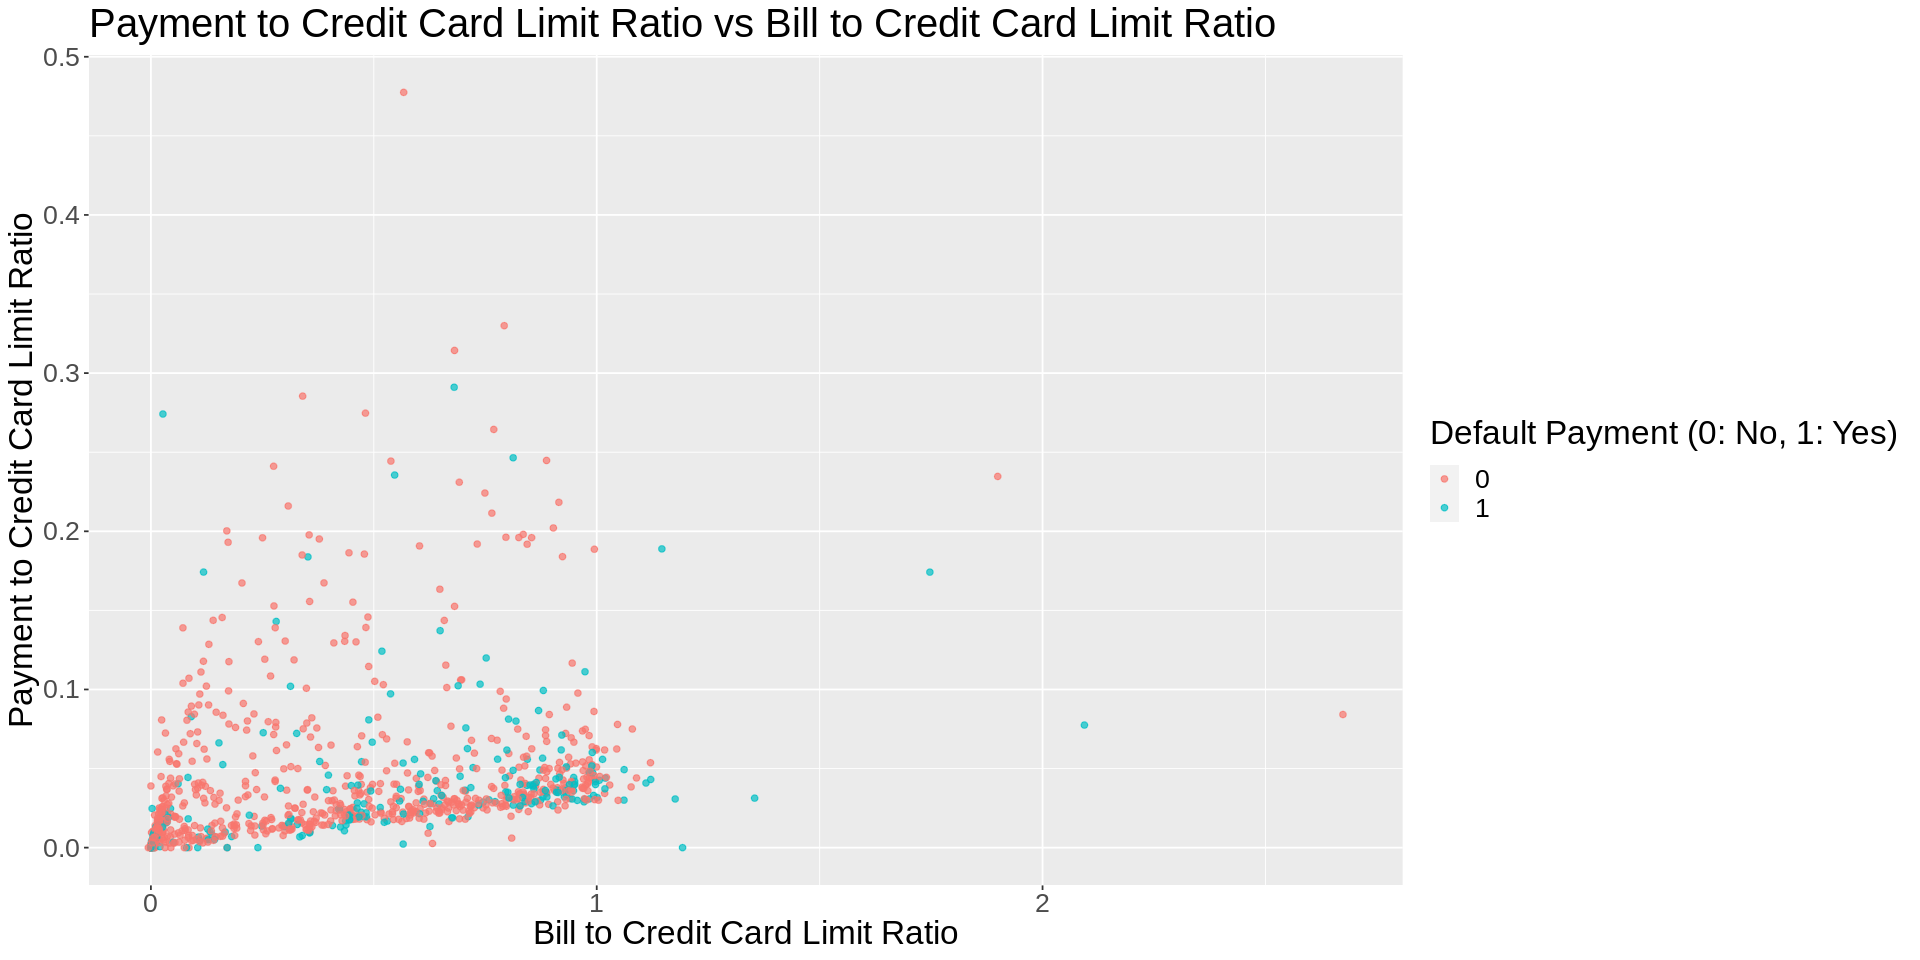

In [45]:
options(repr.plot.width = 16, repr.plot.height = 8)
usage_cdt_pmt_plot <- cd_training_select %>% 
                slice(1:1000) %>% # to avoid overplotting, select 1000 data points 
                ggplot(aes(x = usage_cdt, y = pmt, color = default_nm))+
                geom_point(alpha = 0.7)+
                labs(x = "Bill to Credit Card Limit Ratio", y = "Payment to Credit Card Limit Ratio", color = "Default Payment (0: No, 1: Yes)")+
                theme(text = element_text(size = 20))+
                ggtitle("Payment to Credit Card Limit Ratio vs Bill to Credit Card Limit Ratio")
usage_cdt_pmt_plot

Here, we examine `PAY_0` which represents the payment status in September 2005, the latest information available to us. -1 represents pay dully whereas x represents the payment delay for x months. This indicates that as the payment status `PAY_0` increases the proportion of people who default their payments also increases.

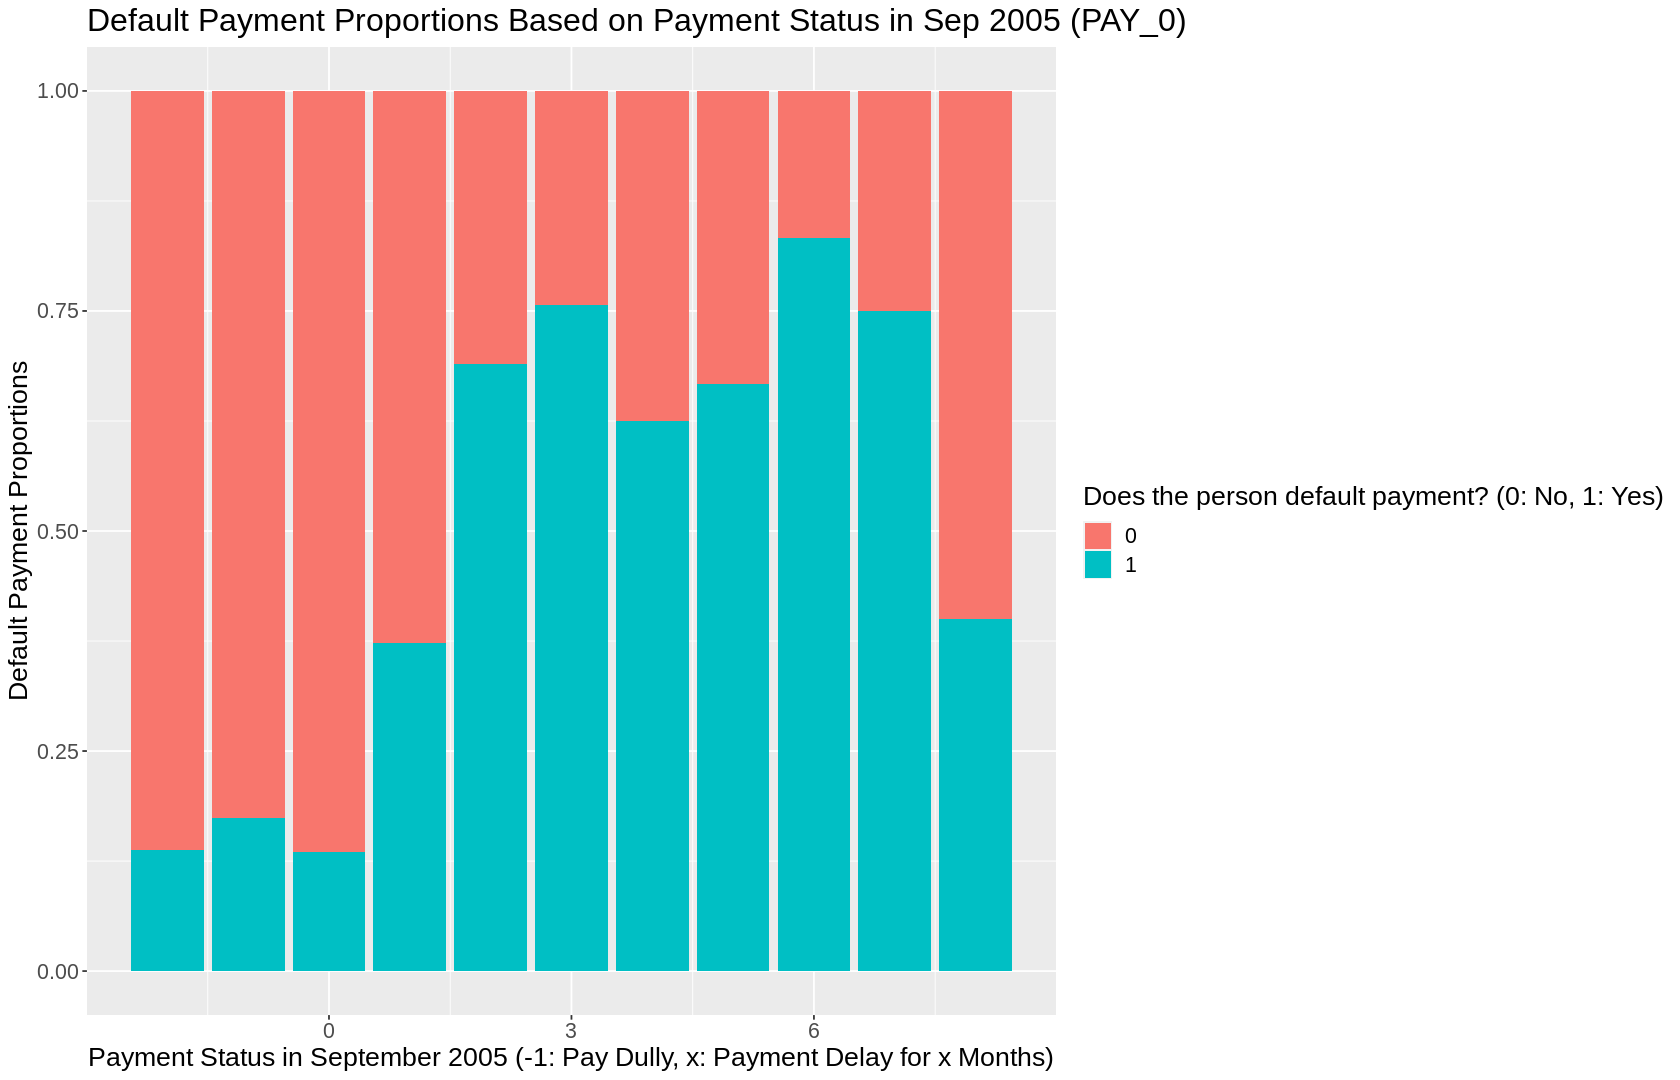

In [19]:
options(repr.plot.width = 14, repr.plot.height = 9)
pay0_plot <- cd_training_select %>%
   ggplot(aes(x = PAY_0, fill = default_nm)) + # to see the affect of PAY_0
   geom_bar(position = 'fill') + 
   xlab("Payment Status in September 2005 (-1: Pay Dully, x: Payment Delay for x Months)") +
   ylab("Default Payment Proportions") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 16))+
   ggtitle("Default Payment Proportions Based on Payment Status in Sep 2005 (PAY_0)")
pay0_plot

This plot below demonstrates the change in number of people who default their payments depending on the `PAY_0`. When `PAY_0` is more than 2 (a person delayed their payment more than 2 months in September 2005), they are more likely to default their payment, because we can see that there are more people who default than not for `PAY_0` >= 2. This makes `PAY_0` a strong predictor variable. 

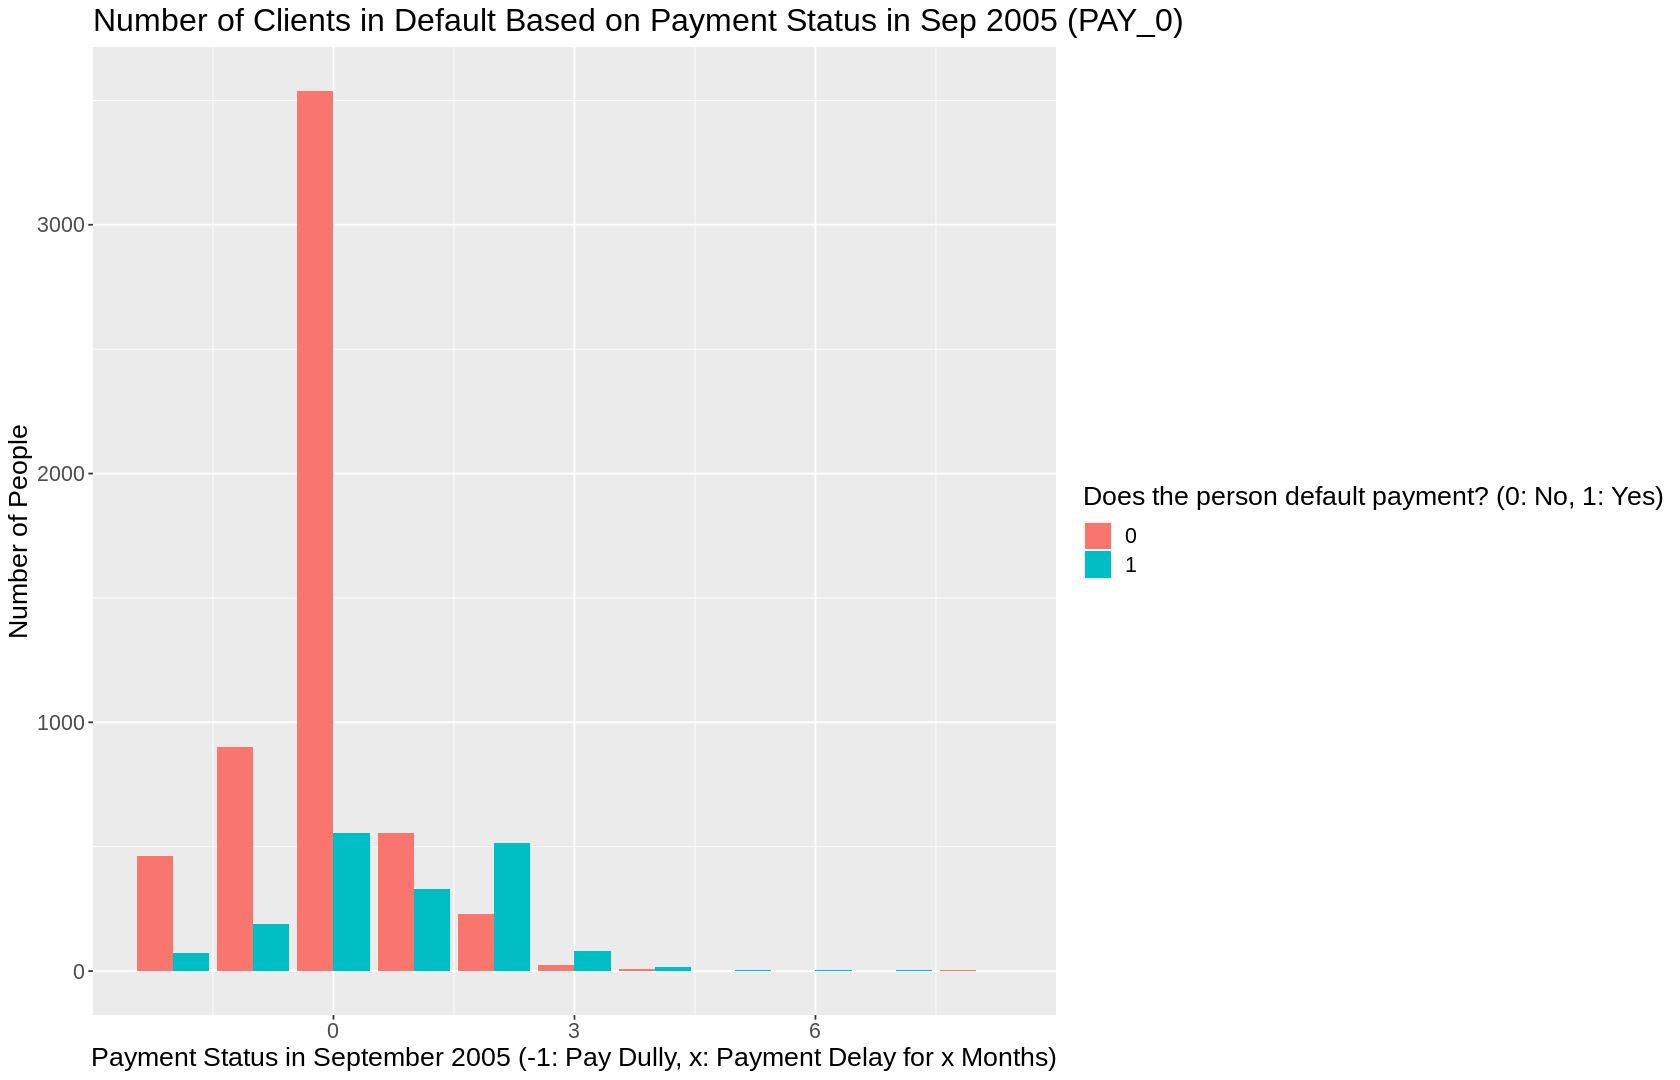

In [20]:
options(repr.plot.width = 14, repr.plot.height = 9)
pay0_plot2 <- cd_training_select %>%
   ggplot(aes(x = PAY_0, fill = default_nm)) + 
   geom_bar(position = 'dodge') + 
   xlab("Payment Status in September 2005 (-1: Pay Dully, x: Payment Delay for x Months)") +
   ylab("Number of People") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 16))+
   ggtitle("Number of Clients in Default Based on Payment Status in Sep 2005 (PAY_0)")
pay0_plot2

Below, we can see that the number of people who default seem to consistently decrease as the credit limit increases. This is because credit limit itself is derived from financial institutions’ analysis of a client’s credit risk. This makes limit a good predictor variable for our model.

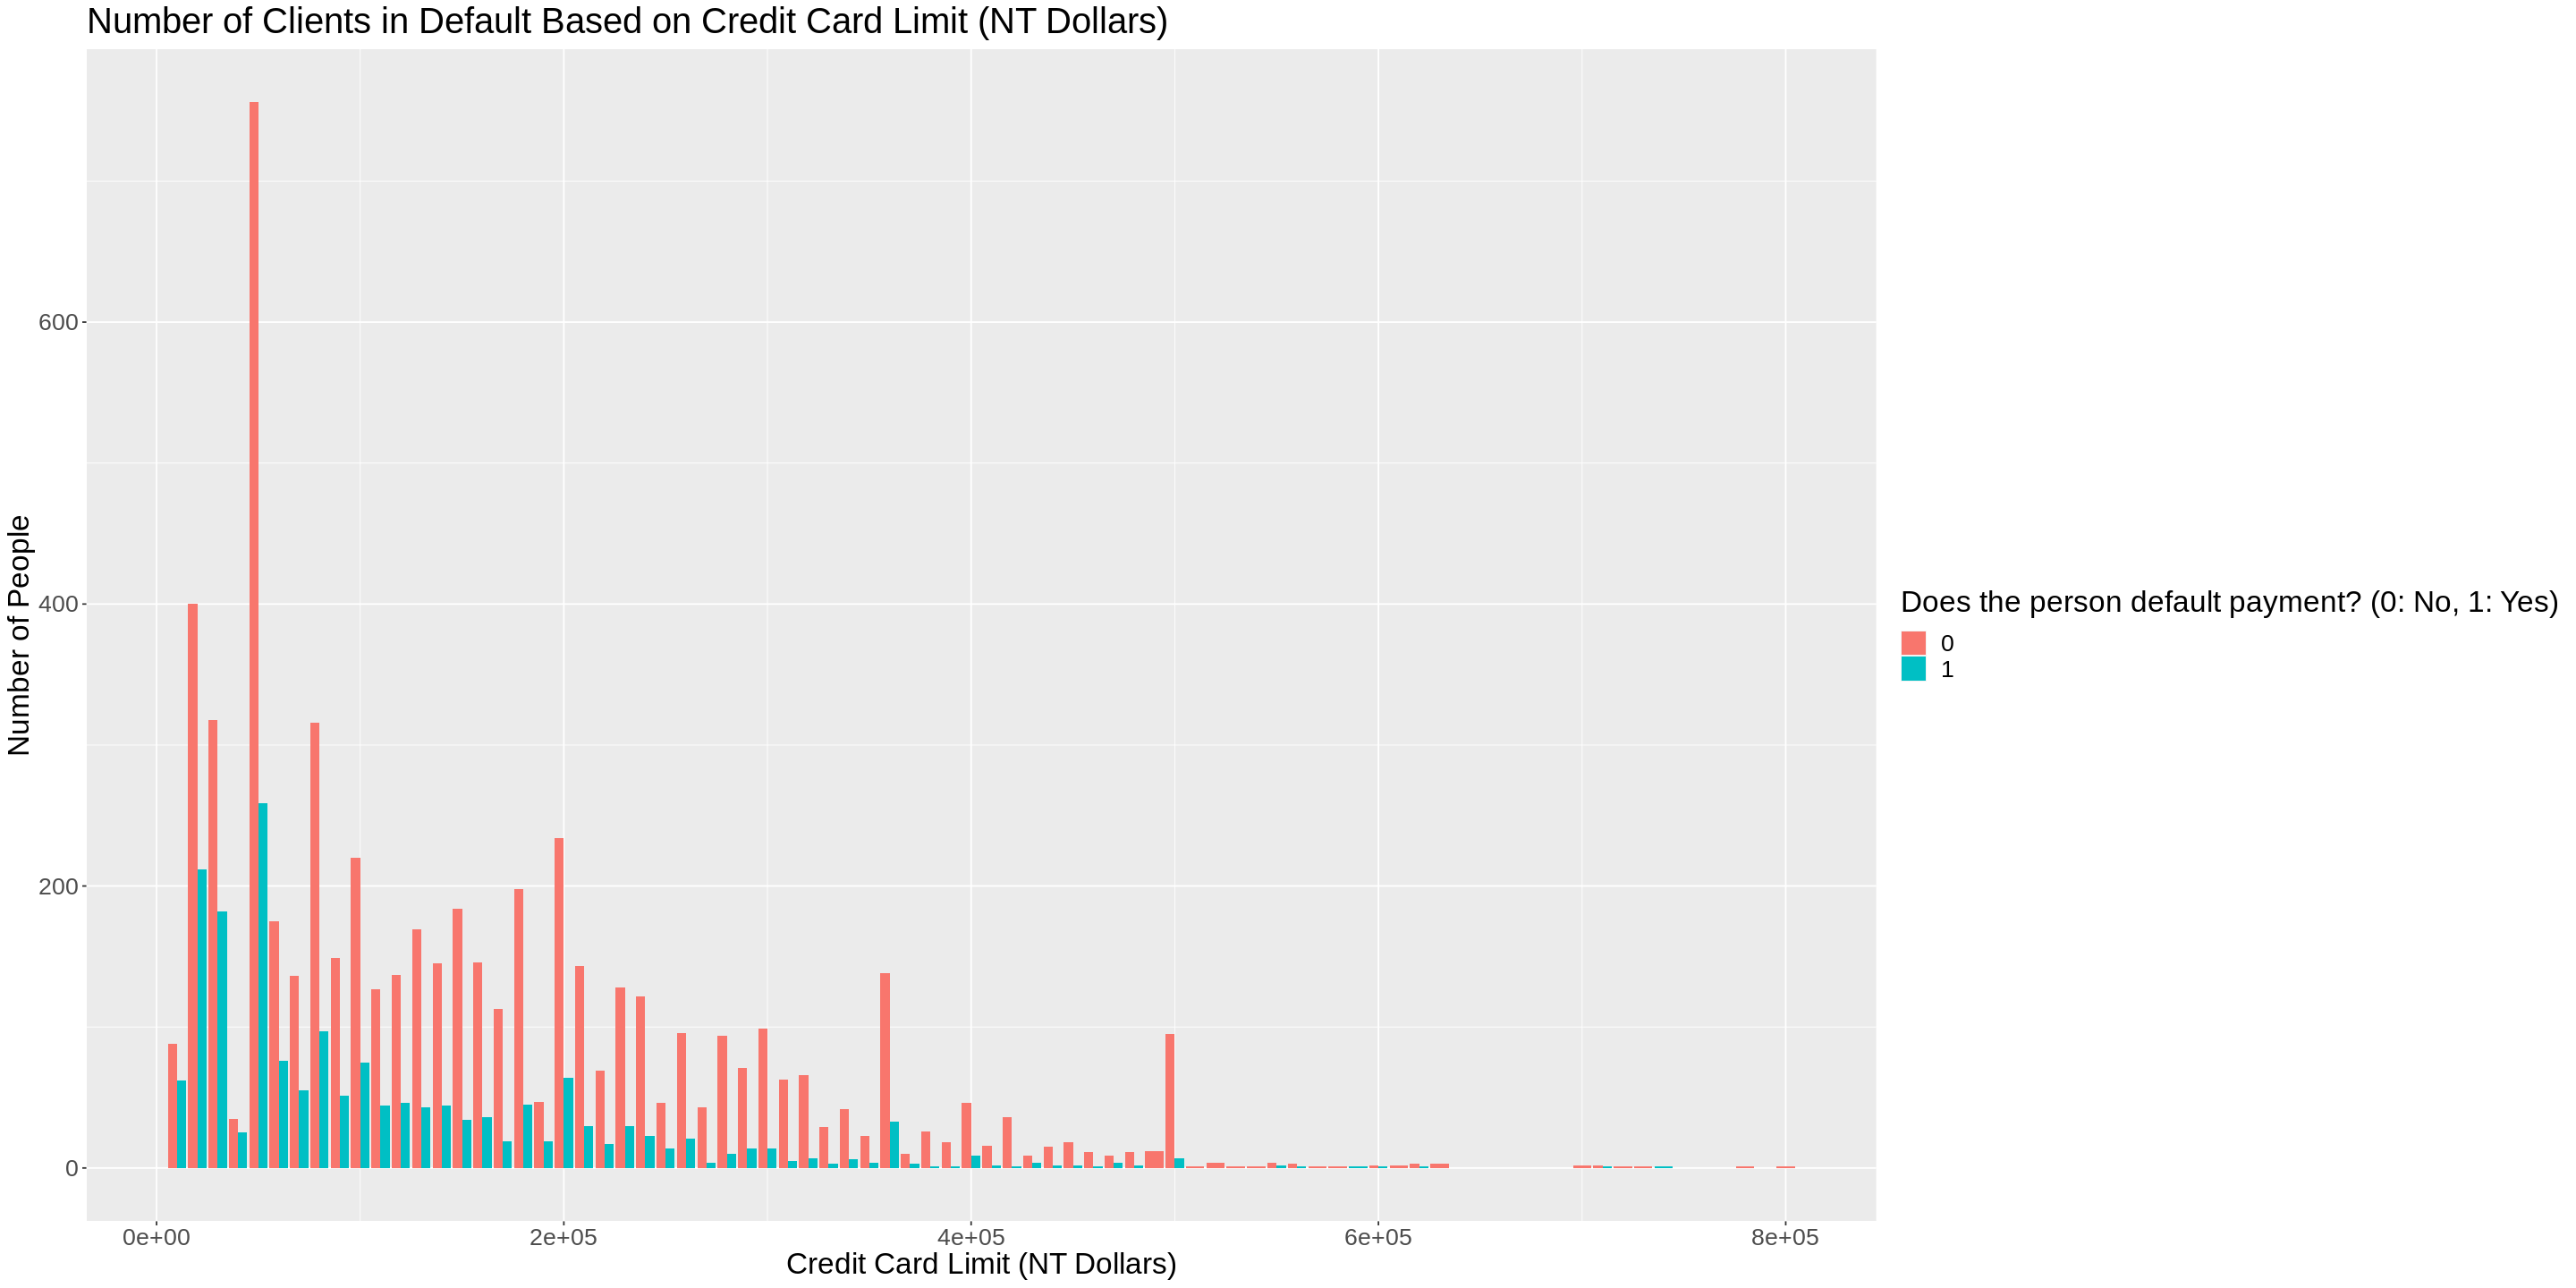

In [23]:
options(repr.plot.width = 24, repr.plot.height = 12)
limit_plot <- cd_training_select %>%
   ggplot(aes(x = limit, fill = default_nm)) + 
   geom_bar(position = 'dodge') + 
   xlab("Credit Card Limit (NT Dollars)") +
   ylab("Number of People") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 20))+
   ggtitle("Number of Clients in Default Based on Credit Card Limit (NT Dollars)")
limit_plot

`pay_overall` is a cumulative sum of the number of months a client is behind/ahead on payments. Positive values represent they are behind on payments and negative values ahead. Notice that the further behind a client is on payments, the more likely they are to be in default.

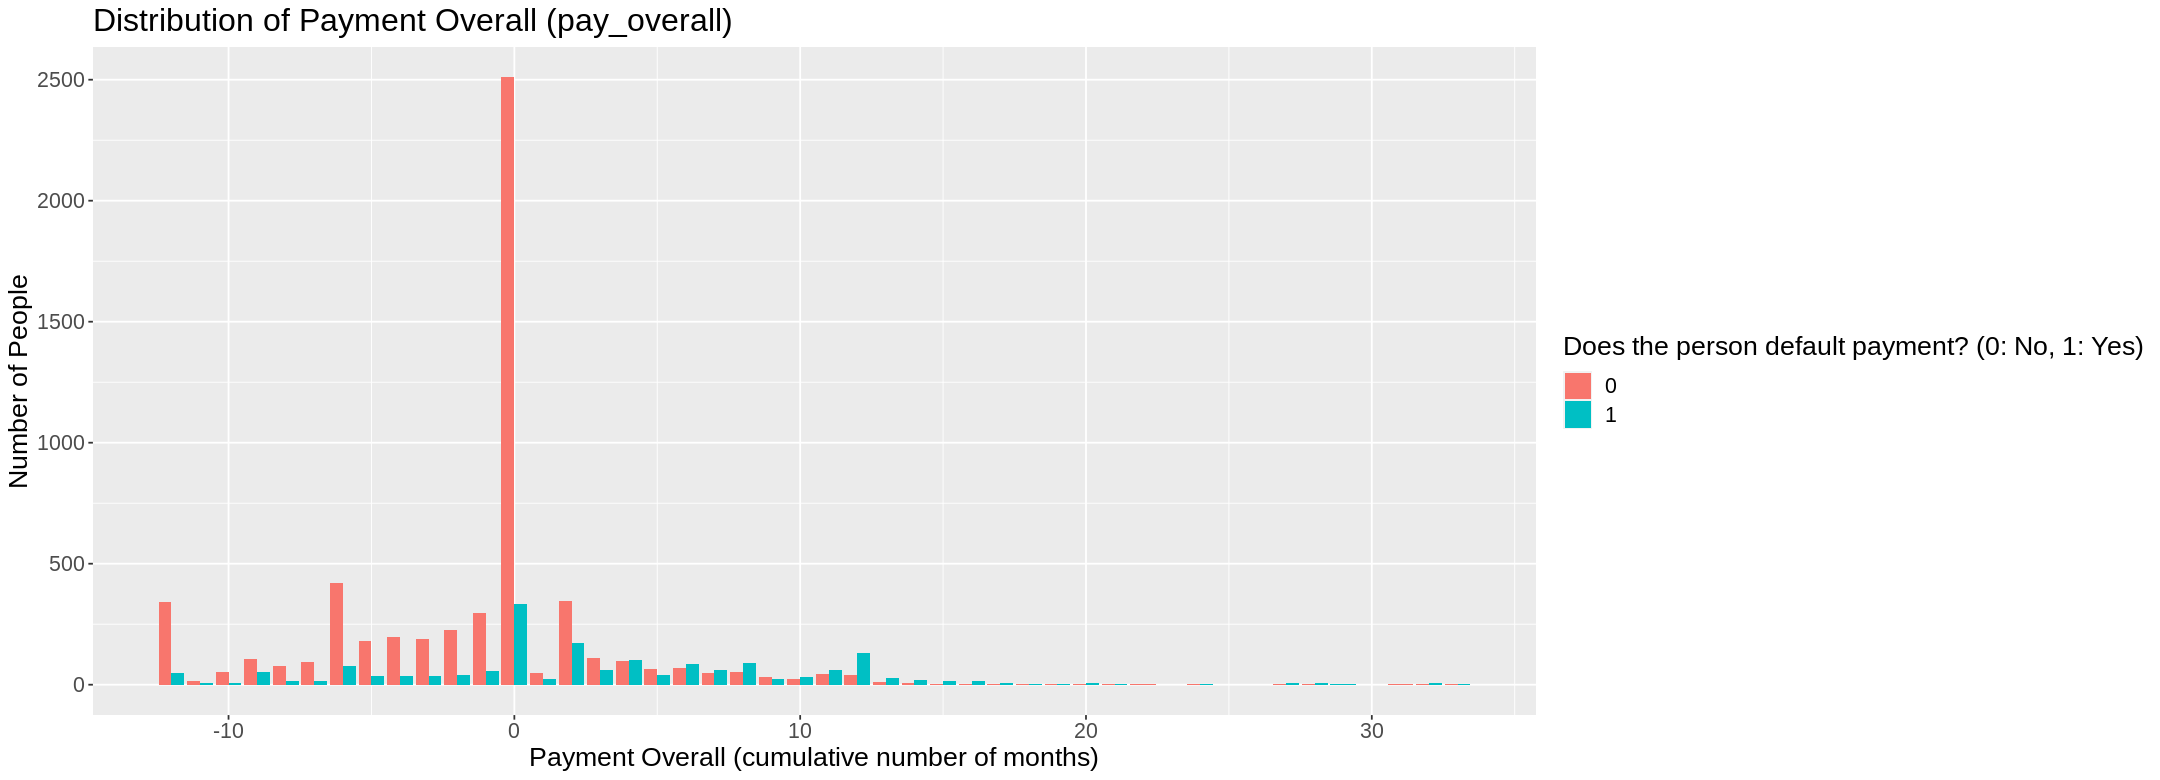

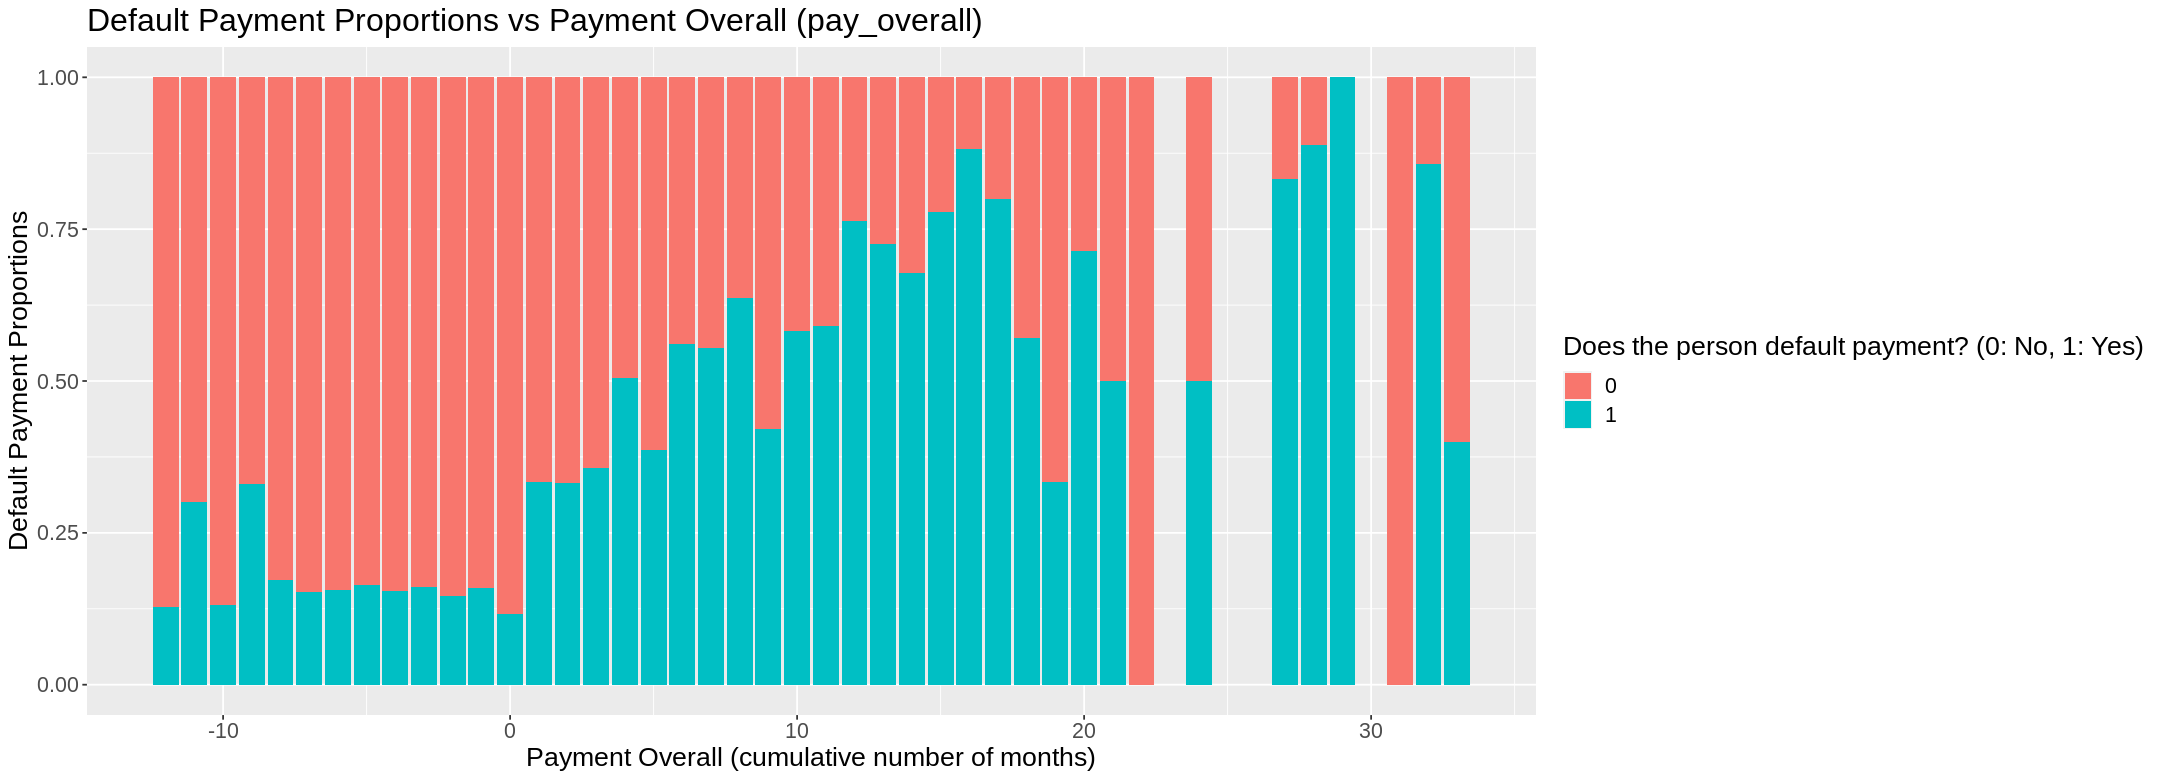

In [53]:
options(repr.plot.width = 18, repr.plot.height = 6.5)
pay_overall_plot <- cd_training_select %>%
   ggplot(aes(x = pay_overall, fill = default_nm)) + 
   geom_bar(position = 'dodge') + 
   xlab("Payment Overall (cumulative number of months)") +
   ylab("Number of People") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 16))+
   ggtitle("Distribution of Payment Overall (pay_overall)")
pay_overall_plot
pay_overall_plot2 <- cd_training_select %>%
   ggplot(aes(x = pay_overall, fill = default_nm)) + 
   geom_bar(position = 'fill') + 
   xlab("Payment Overall (cumulative number of months)") +
   ylab("Default Payment Proportions") +
   labs(fill = "Does the person default payment? (0: No, 1: Yes)")+
   theme(text = element_text(size = 16))+
   ggtitle("Default Payment Proportions vs Payment Overall (pay_overall)")
pay_overall_plot2

### Fitting the Model

We conduct our analysis using a K-nearest neighbors classification model with `default_nm` as our classification variable. For our predictors we will use `limit`, `usage_cdt`, `pmt`, `pay_overall` and `PAY_0` since they are strongly related to default as discussed earlier. Our data consists of 10,000 observations of university educated individuals with 75% of the data making up the training set and 25% making up the testing set. 


Here, we create  our KNN model specifications for cross-validation.

In [48]:
cd_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

Below, we make our recipe, center and scale all of our predictor variables to make sure that all of our variables affect the prediction in the same scale. If we were to not do this, we would have gotten a result such that credit card limit `limit` affects the default prediction a lot more than `PAY_0`, because `limit` values are larger than `PAY_0` values.

In [54]:
cd_recipe <- recipe(default_nm ~ limit + usage_cdt + pmt + PAY_0 + pay_overall, data = cd_training_select) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

Here, we use 5 fold cross-validation to find the best K value for our classification model, this will increase our model's accuracy and help us generalize and predict on the testing set as well. We create a tibble of K values from 1 to 30, put our recipe and model specs into a workflow and output a table of accuracies.

In [77]:
set.seed(19)
cd_vfold <- vfold_cv(cd_training_select, v=5, strata= default_nm) # cross-validation with 5 folds 

grids <- tibble(neighbors = seq(1, 25)) # to do cross-validation with 25 different number of K values

cd_acc <- workflow() %>%
            add_recipe(cd_recipe) %>%
            add_model(cd_spec) %>%
            tune_grid(resamples = cd_vfold, grid=grids) %>%
            collect_metrics() %>%
            filter(.metric == "accuracy")
cd_acc

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7179034,5,0.005111938,Model01
2,accuracy,binary,0.7177700,5,0.004959802,Model02
3,accuracy,binary,0.7741621,5,0.004679094,Model03
4,accuracy,binary,0.7746954,5,0.004428425,Model04
5,accuracy,binary,0.7929596,5,0.006162592,Model05
6,accuracy,binary,0.7938930,5,0.006296449,Model06
7,accuracy,binary,0.7977592,5,0.006963457,Model07
8,accuracy,binary,0.7976258,5,0.006893017,Model08
9,accuracy,binary,0.8018933,5,0.005936165,Model09


We visualize the accuracy for different K values as a line plot.

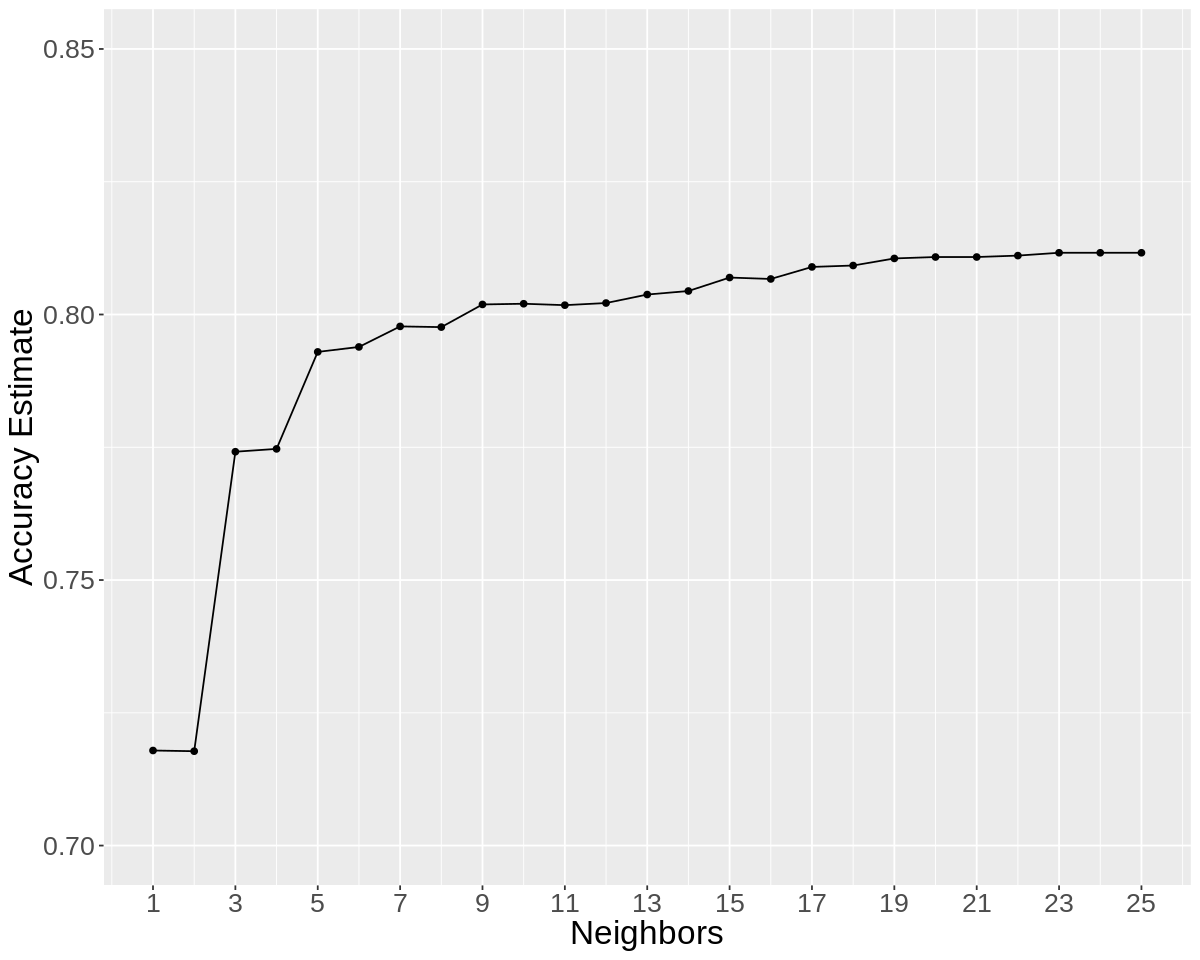

In [83]:
options(repr.plot.width = 10, repr.plot.height = 8)
cross_val_plot <- ggplot(cd_acc, aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x="Neighbors", y="Accuracy Estimate") +
                theme(text = element_text(size = 20)) +
                scale_x_continuous(breaks = seq(1, 25, by = 2)) +  # adjusting the x-axis
                scale_y_continuous(limits = c(0.7, 0.85)) # adjusting the y-axis
cross_val_plot

In [84]:
best_k <- cd_acc %>%
        arrange(desc(mean)) %>%
        slice(1) %>%
        pull(neighbors)
best_k

[1] 23

In [ ]:
usage_cdt = ((BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6)/6)/limit, # column that measures average proportion of credit limit that is used over the time period
              pmt = ((PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6)/6)/limit) %>% # column that measures average proportion of credit limit that is paid over the time period

select(-ID, -SEX, -EDUCATION, -MARRIAGE, -AGE)
head(cd_sample)
tail(cd_sample)

SPLIT TESTTT

In [8]:
cd_university_mutated <- cd_university %>%
        rename(default_nm = default.payment.next.month) %>%
        mutate(default_nm = as_factor(default_nm)) %>%
        mutate(pay_avg = (PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6)/6) %>%
        mutate(bill_avg = (BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6))

head(cd_university_mutated)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_nm,pay_avg,bill_avg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,689,0,0,0,0,1,114.8333,7704
2,120000,2,2,2,26,-1,2,0,0,⋯,3261,0,1000,1000,1000,0,2000,1,833.3333,17077
3,90000,2,2,2,34,0,0,0,0,⋯,15549,1518,1500,1000,1000,1000,5000,0,1836.3333,101653
4,50000,2,2,1,37,0,0,0,0,⋯,29547,2000,2019,1200,1100,1069,1000,0,1398.0000,231334
5,50000,1,2,1,57,-1,0,-1,0,⋯,19131,2000,36681,10000,9000,689,679,0,9841.5000,109339
8,100000,2,2,2,23,0,-1,-1,0,⋯,567,380,601,0,581,1687,1542,0,798.5000,13486


In [29]:
# cd_corr <- ggpairs(cd_university_mutated)
# cd_corr


In [9]:
cd_split <- initial_split(cd_university_mutated, prop=0.75, strata=default_nm)
cd_training <- training(cd_split)
cd_testing <- testing(cd_split)

In [22]:
cd_uni <- cd_training %>%
        mutate(payment_to_bill_ratio = pay_avg/bill_avg) %>%  # the ratio of their average payment to average bill    
        mutate(usage_cdt = bill_avg/LIMIT_BAL) %>% # to see how much of their balance they use 
        mutate(pmt = pay_avg/LIMIT_BAL) %>% # to see how much of their balance they pay
        mutate(diff_usage_pmt = usage_cdt - pmt) %>% # 
        select(LIMIT_BAL, PAY_0, bill_avg, pay_avg, usage_cdt, pmt, diff_usage_pmt, PAY_6, default_nm)
head(cd_uni)
#cd_uni

LIMIT_BAL,PAY_0,bill_avg,pay_avg,usage_cdt,pmt,diff_usage_pmt,PAY_6,default_nm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
90000,0,101653,1836.3333,1.12947778,0.020403704,1.10907407,0,0
50000,-1,109339,9841.5000,2.18678000,0.196830000,1.98995000,0,0
100000,0,13486,798.5000,0.13486000,0.007985000,0.12687500,-1,0
630000,-1,41007,3895.0000,0.06509048,0.006182540,0.05890794,-1,0
120000,-1,1896,263.3333,0.01580000,0.002194444,0.01360556,-1,1
70000,2,265475,1835.0000,3.79250000,0.026214286,3.76628571,2,1


In [28]:
# options(repr.plot.width = 10, repr.plot.height = 8)
# cd_corr <- select(cd_uni, PAY_0, default_nm) %>% ggpairs()
# cd_corr


In [ ]:
#cd_corr 

In [15]:
cd_recipe <- recipe(default_nm ~ LIMIT_BAL + usage_cdt + pmt + PAY_0, data = cd_uni) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

cd_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")
#cd_recipe
cd_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [17]:
cd_vfold <- vfold_cv(cd_uni, v=5, strata= default_nm)

grids <- tibble(neighbors = seq(1, 50, 3))

cd_results <- workflow() %>%
            add_recipe(cd_recipe) %>%
            add_model(cd_spec) %>%
            tune_grid(resamples = cd_vfold, grid=grids) %>%
            collect_metrics()
cd_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7201367,5,0.002425915,Model01
1,roc_auc,binary,0.6123526,5,0.002927261,Model01
4,accuracy,binary,0.7680321,5,0.002067549,Model02
4,roc_auc,binary,0.6965768,5,0.002940774,Model02
7,accuracy,binary,0.7949259,5,0.002572713,Model03
7,roc_auc,binary,0.7179940,5,0.006318236,Model03
10,accuracy,binary,0.7992027,5,0.002734419,Model04
10,roc_auc,binary,0.7294159,5,0.006192167,Model04
13,accuracy,binary,0.8055700,5,0.003130852,Model05


# Discussion 

# References 